In [1]:
from main_functions import *
from shared_block_optimization import *
from gt_extension import *
from utils import *
from datetime import datetime
import pickle
import matplotlib.pyplot as plt
import re

np.set_printoptions(suppress=True)
np.set_printoptions(precision=3)

plt_width = 3.3125
plt.rcParams.update({'font.family': 'serif', 'font.serif': 'Times New Roman', 'font.size': 10, 'figure.figsize': (plt_width, 2.0)})
#plt.rcParams.update({'text.usetex': True})


In [136]:
import importlib
import main_functions, shared_block_optimization, utils
importlib.reload(main_functions)
importlib.reload(shared_block_optimization)
importlib.reload(utils)
from main_functions import *
from shared_block_optimization import *
from utils import *

In [9]:
seed = 123
np.random.seed(seed)
gt.seed_rng(seed)

n_graphs = 3
block_counts = (4, 4, 4)
vertex_counts = (200, 200, 200)
n_shared_blocks = 2
using_directed_graphs = True
all_algorithms = [
    (shared_blocks_random, "Random"),
    (optimize_shared_blocks_greedy, "Greedy"),
    (optimize_shared_blocks_ILP, "ILP"),
]

n_tests = 20
shared_block_mean_ARIs = [[] for _ in range(len(all_algorithms))]
total_running_times = [[] for _ in range(len(all_algorithms))]
shared_log_likelihoods = [[] for _ in range(len(all_algorithms))]
plotting = False
verbose = True
for i in range(n_tests):
    Gs, Ps, shared_block_sets, block_assignments = generate_shared_SBMs(n_graphs, block_counts, vertex_counts, n_shared_blocks, using_directed_graphs, seed=seed+i)
    inference_start_time = datetime.now()
    states, inferred_block_assignments = fit_SBMs(Gs, block_counts)
    inferred_block_counts = get_block_counts(inferred_block_assignments)
    if verbose:
        print(f"Fitting SBMs done in: {datetime.now() - inference_start_time}")
    if plotting:
        layouts = plot_ground_truth_SBMs(Gs, block_assignments)
        plot_inferred_SBMs(Gs, states, layouts)
    edge_count_matrices, missing_edges_matrices = calculate_edge_counts_and_missing_edges(inferred_block_assignments, Gs, using_directed_graphs)
    inferred_Ps = compute_max_likelihood_params(edge_count_matrices, missing_edges_matrices)
    for i, algorithm in enumerate(all_algorithms):
        alg_function, alg_name = algorithm
        inference_start_time = datetime.now()
        inferred_shared_Ps, inferred_shared_blocks, inferred_shared_block_sets = alg_function(n_shared_blocks, inferred_Ps, inferred_block_counts, edge_count_matrices, missing_edges_matrices)
        total_running_time = datetime.now() - inference_start_time
        ARIs = compare_shared_blocks_ARI(Gs, inferred_block_assignments, inferred_shared_block_sets, block_assignments, shared_block_sets)
        log_likelihood = compute_log_likelihood(inferred_shared_Ps, edge_count_matrices, missing_edges_matrices, using_directed_graphs)
        if verbose:
            print(f"{alg_name} done in: {total_running_time}, ARIs: {list(ARIs)}, log-likelihood: {log_likelihood}")
        shared_block_mean_ARIs[i].append(np.mean(ARIs, axis=0))
        total_running_times[i].append(total_running_time)
        shared_log_likelihoods[i].append(log_likelihood)
    if verbose:
        print()
for i, (_, alg_name) in enumerate(all_algorithms):
    print(f"{alg_name}: mean over {n_tests} runs: ARIs: {np.mean(shared_block_mean_ARIs[i], axis=0)}, running time (s): {np.mean(total_running_times[i]).total_seconds():.3f}, log likelihood: {np.mean(shared_log_likelihoods[i]):.3f}")

Fitting SBMs done in: 0:00:02.279850
Random done in: 0:00:00.000156, ARIs: [array([0.092, 0.434]), array([0.124, 0.635]), array([0.017, 0.868])], log-likelihood: -59149.97479961161
Greedy done in: 0:00:00.019562, ARIs: [array([1., 1.]), array([1., 1.]), array([1., 1.])], log-likelihood: -55840.1702207164
ILP done in: 0:00:01.257318, ARIs: [array([1., 1.]), array([1., 1.]), array([1., 1.])], log-likelihood: -55840.1702207164

Fitting SBMs done in: 0:00:03.494359
Random done in: 0:00:00.000154, ARIs: [array([0.271, 0.939]), array([0.352, 0.795]), array([1., 1.])], log-likelihood: -61944.010355959086
Greedy done in: 0:00:00.020012, ARIs: [array([1., 1.]), array([1., 1.]), array([1., 1.])], log-likelihood: -61154.51299719782
ILP done in: 0:00:01.439624, ARIs: [array([1., 1.]), array([1., 1.]), array([1., 1.])], log-likelihood: -61154.51299719782

Fitting SBMs done in: 0:00:02.016771
Random done in: 0:00:00.000163, ARIs: [array([0.072, 0.809]), array([-0.005,  0.596]), array([1.   , 0.704])

In [18]:
from IPython.display import display, Latex
from tabulate import tabulate

table = []
for i, (_, alg_name) in enumerate(all_algorithms):
    mean_ARIs_i = np.mean(shared_block_mean_ARIs[i], axis=0)
    std_ARIs_i = np.std(shared_block_mean_ARIs[i], axis=0)

    row = [
        alg_name, 
        f"${mean_ARIs_i[0]:.2f} (\\pm {std_ARIs_i[0]:.2f})$", 
        f"${mean_ARIs_i[1]:.2f} (\\pm {std_ARIs_i[1]:.2f})$", 
        f"${np.mean(shared_log_likelihoods[i]):.2f} (\\pm {np.std(shared_log_likelihoods[i]):.2f})$"
    ]
    table.append(row)

headers = ["Algorithm", "ARI 1", "ARI 2", "Log-Likelihood"]

latex_table = (
    tabulate(table, headers, tablefmt="latex_raw")
)

# Replace \hline with \toprule, \midrule, and \bottomrule
latex_table = latex_table.replace("\\hline", "\\toprule", 1)
latex_table = latex_table.replace("\\hline", "\\midrule", 1)
latex_table = latex_table.replace("\\hline", "\\bottomrule", 1)

print(f"Number of runs: {n_tests}")
display(Latex(latex_table_to_mathjax(latex_table)))
print(latex_table)

Number of runs: 20


<IPython.core.display.Latex object>

\begin{tabular}{llll}
\toprule
 Algorithm   & ARI 1             & ARI 2             & Log-Likelihood            \\
\midrule
 Random      & $0.38 (\pm 0.22)$ & $0.62 (\pm 0.19)$ & $-61090.31 (\pm 5543.07)$ \\
 Greedy      & $0.86 (\pm 0.25)$ & $0.91 (\pm 0.18)$ & $-58460.65 (\pm 6103.73)$ \\
 ILP         & $0.92 (\pm 0.18)$ & $0.93 (\pm 0.18)$ & $-58433.30 (\pm 6096.29)$ \\
\bottomrule
\end{tabular}


In [2]:
results_file_name = "inference_comparison_test"
results = pickle.load(open(results_file_name+".pkl", "rb"))
inference_algorithms, shared_block_optimization_algs, mean_partition_ARIs, inference_running_times, single_log_likelihoods, single_BICs, single_edge_P_MAEs, shared_block_mean_ARIs, total_running_times, shared_log_likelihoods, shared_BICs, shared_edge_P_MAEs = results

In [3]:
from IPython.display import display, Latex
from tabulate import tabulate

table = []
for i, (_, alg_name, _) in enumerate(inference_algorithms):
    row = [
        alg_name, 
        f"${np.mean(mean_partition_ARIs[i]):.4f} (\\pm {np.std(mean_partition_ARIs[i]):.4f})$",
        f"${np.mean(single_log_likelihoods[i]):.2f} (\\pm {np.std(single_log_likelihoods[i]):.2f})$",
        f"${np.mean(single_BICs[i]):.2f} (\\pm {np.std(single_BICs[i]):.2f})$",
        f"${np.mean(single_edge_P_MAEs[i]):.4f} (\\pm {np.std(single_edge_P_MAEs[i]):.4f})$",
        f"${np.mean(inference_running_times[i]).total_seconds():.2f}$"
    ]
    table.append(row)

headers = ["Algorithm", "partition ARI", "Log-Likelihood", "BIC", "Edge Probability MAE", "Time (s)"]

latex_table = (
    tabulate(table, headers, tablefmt="latex_raw")
)

# Replace \hline with \toprule, \midrule, and \bottomrule
latex_table = latex_table.replace("\\hline", "\\toprule", 1)
latex_table = latex_table.replace("\\hline", "\\midrule", 1)
latex_table = latex_table.replace("\\hline", "\\bottomrule", 1)

print(f"Number of runs: {len(mean_partition_ARIs[0])}")
display(Latex(latex_table_to_mathjax(latex_table)))
print(latex_table)

Number of runs: 10


<IPython.core.display.Latex object>

\begin{tabular}{llllll}
\toprule
 Algorithm                      & partition ARI         & Log-Likelihood              & BIC                        & Edge Probability MAE   & Time (s)   \\
\midrule
 bernoulli single SBMs          & $0.9113 (\pm 0.0681)$ & $-326615.04 (\pm 38623.45)$ & $654244.52 (\pm 77246.90)$ & $0.0222 (\pm 0.0173)$  & $2.08$     \\
 bernoulli shared SBM           & $0.9126 (\pm 0.0546)$ & $-334566.00 (\pm 34295.81)$ & $670146.45 (\pm 68591.62)$ & $0.0364 (\pm 0.0248)$  & $2.03$     \\
 poisson multilevel single SBMs & $0.9988 (\pm 0.0024)$ & $-318104.77 (\pm 38475.01)$ & $637223.99 (\pm 76950.02)$ & $0.0026 (\pm 0.0014)$  & $17.47$    \\
 two-step single SBMs           & $0.9810 (\pm 0.0569)$ & $-317819.18 (\pm 38296.45)$ & $636652.79 (\pm 76592.89)$ & $0.0025 (\pm 0.0008)$  & $19.47$    \\
 two-step shared SBMs           & $0.9995 (\pm 0.0015)$ & $-317836.90 (\pm 38284.77)$ & $636688.23 (\pm 76569.54)$ & $0.0022 (\pm 0.0003)$  & $91.85$    \\
\bottomrule
\end{tabul

In [5]:
from IPython.display import display, Latex
from tabulate import tabulate

table = []
for j, (_, shared_block_alg_name) in enumerate(shared_block_optimization_algs):
    for i, (_, inference_alg_name, _) in enumerate(inference_algorithms):
        if "shared" in inference_alg_name and "Random" in shared_block_alg_name:
            continue
        if "single" in inference_alg_name and "Firsts" in shared_block_alg_name:
            continue
        mean_ARIs_i = np.mean(shared_block_mean_ARIs[i][j], axis=0)
        std_ARIs_i = np.std(shared_block_mean_ARIs[i][j], axis=0)

        row = [
            inference_alg_name + "+" + shared_block_alg_name, 
            #f"${mean_ARIs_i[0]:.2f} (\\pm {std_ARIs_i[0]:.2f})$", 
            #f"${mean_ARIs_i[1]:.2f} (\\pm {std_ARIs_i[1]:.2f})$", 
            #f"${np.mean(shared_log_likelihoods[i][j]):.2f} (\\pm {np.std(shared_log_likelihoods[i][j]):.2f})$",
            #f"${np.mean(shared_BICs[i][j]):.2f} (\\pm {np.std(shared_BICs[i][j]):.2f})$",
            #f"${np.mean(shared_edge_P_MAEs[i][j]):.4f} (\\pm {np.std(shared_edge_P_MAEs[i][j]):.4f})$",
            f"${mean_ARIs_i[0]:.2f}$", 
            f"${mean_ARIs_i[1]:.2f}$", 
            f"${np.mean(shared_log_likelihoods[i][j]):.2f}$",
            f"${np.mean(shared_BICs[i][j]):.2f}$",
            f"${np.mean(shared_edge_P_MAEs[i][j]):.4f}$",
            f"${np.mean(total_running_times[i][j]).total_seconds():.2f}$"
        ]
        table.append(row)
# binary shared ari = how well the binary partition of vertices into shared or non-shared blocks matches the ground truth
# shared partition ari = how well the partition into shared blocks (with all other blocks having a common label) matches the ground truth
headers = ["Algorithm", "Binary Shared ARI", "Shared Partition ARI", "Log-Likelihood", "BIC", "Edge Probability MAE", "Time (s)"]

latex_table = (
    tabulate(table, headers, tablefmt="latex_raw")
)

# Replace \hline with \toprule, \midrule, and \bottomrule
latex_table = latex_table.replace("\\hline", "\\toprule", 1)
latex_table = latex_table.replace("\\hline", "\\midrule", 1)
latex_table = latex_table.replace("\\hline", "\\bottomrule", 1)

print(f"Number of runs: {len(shared_log_likelihoods[0][0])}")
display(Latex(latex_table_to_mathjax(latex_table)))

print(latex_table)

Number of runs: 10


<IPython.core.display.Latex object>

\begin{tabular}{lllllll}
\toprule
 Algorithm                             & Binary Shared ARI   & Shared Partition ARI   & Log-Likelihood   & BIC         & Edge Probability MAE   & Time (s)   \\
\midrule
 bernoulli single SBMs+Random          & $0.32$              & $0.66$                 & $-359622.26$     & $720015.48$ & $0.0767$               & $2.08$     \\
 poisson multilevel single SBMs+Random & $0.33$              & $0.72$                 & $-355534.48$     & $711839.92$ & $0.0604$               & $17.47$    \\
 two-step single SBMs+Random           & $0.32$              & $0.71$                 & $-355313.55$     & $711398.07$ & $0.0604$               & $19.47$    \\
 bernoulli shared SBM+Firsts           & $0.49$              & $0.56$                 & $-340012.15$     & $680795.26$ & $0.0461$               & $2.03$     \\
 two-step shared SBMs+Firsts           & $0.98$              & $0.99$                 & $-317865.49$     & $636501.96$ & $0.0020$               & $91.85$    

In [29]:
n_steps = 100
inference_algorithms = [
    (fit_SBMs_bernoulli, "Single", n_steps),
    (fit_shared_SBM, "Shared", n_steps),
    (fit_SBMs, "Multilevel", None),
    (fit_single_SBMs_twostep, "ML+Single", n_steps),
    (fit_shared_SBM_twostep, "ML+Shared", n_steps),
]
shared_block_optimization_algs = [
    (shared_blocks_random, "Random"),
    (firsts_as_shared_blocks, "Firsts"),
    (optimize_shared_blocks_greedy, "Greedy"),
    (optimize_shared_blocks_ILP, "ILP"),
]

all_algorithms = []
plot_partition_ARIs = []
plot_binary_shared_ARIs = []
plot_shared_blocks_ARIs = []
plot_log_likelihoods = []
plot_BICs = []
colors = ['red', 'blue', 'green', 'orange', 'purple']
plot_colors = []

for i, (_, inference_alg_name, _) in enumerate(inference_algorithms):
    all_algorithms.append(inference_alg_name)
    plot_partition_ARIs.append(np.mean(mean_partition_ARIs[i]))
    plot_log_likelihoods.append(np.mean(single_log_likelihoods[i]))
    plot_BICs.append(np.mean(single_BICs[i]))
    plot_colors.append(colors[i])

for j, (_, shared_block_alg_name) in enumerate(shared_block_optimization_algs):
    for i, (_, inference_alg_name, _) in enumerate(inference_algorithms):
        all_algorithms.append(inference_alg_name + "+" + shared_block_alg_name)
        mean_ARIs_i = np.mean(shared_block_mean_ARIs[i][j], axis=0)
        plot_binary_shared_ARIs.append(mean_ARIs_i[0])
        plot_shared_blocks_ARIs.append(mean_ARIs_i[1])
        plot_log_likelihoods.append(np.mean(shared_log_likelihoods[i][j]))
        plot_BICs.append(np.mean(shared_BICs[i][j]))
        plot_colors.append(colors[i])

all_algorithms = np.array(all_algorithms)
plot_partition_ARIs = np.array(plot_partition_ARIs)
plot_binary_shared_ARIs = np.array(plot_binary_shared_ARIs)
plot_shared_blocks_ARIs = np.array(plot_shared_blocks_ARIs)
plot_log_likelihoods = np.array(plot_log_likelihoods)
plot_BICs = np.array(plot_BICs)
plot_colors = np.array(plot_colors)

single_algorithms = all_algorithms[:len(inference_algorithms)]
shared_algorithms = all_algorithms[len(inference_algorithms):]

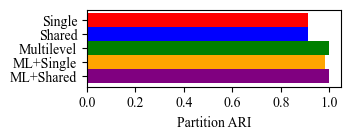

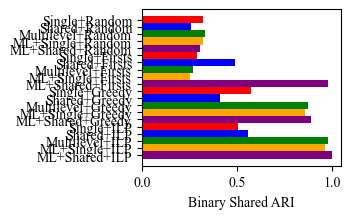

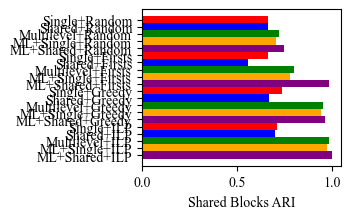

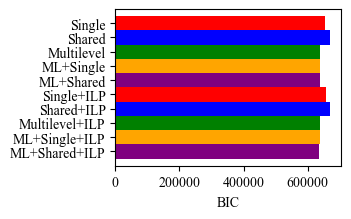

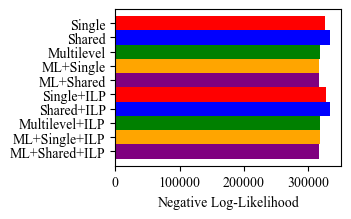

In [218]:
plt.figure(figsize = (plt_width, 1.2))
plt.barh(single_algorithms, plot_partition_ARIs, color=plot_colors, height=1.0)
plt.xlabel('Partition ARI')
plt.gca().invert_yaxis()
plt.tight_layout(pad=0.0)
#plt.savefig("figures/Partition_ARI.pdf")
plt.show()

plt.barh(shared_algorithms, plot_binary_shared_ARIs, color=plot_colors[len(inference_algorithms):], height=1.0)
plt.xlabel('Binary Shared ARI')
plt.gca().invert_yaxis()
plt.tight_layout(pad=0.0)
#plt.savefig("figures/Binary_Shared_ARI.pdf")
plt.show()


plt.barh(shared_algorithms, plot_shared_blocks_ARIs, color=plot_colors[len(inference_algorithms):], height=1.0)
plt.xlabel('Shared Blocks ARI')
plt.gca().invert_yaxis()
plt.tight_layout(pad=0.0)
#plt.savefig("figures/Shared_Blocks_ARI.pdf")
plt.show()

single_i = np.arange(len(inference_algorithms))#[2:]
ILP_i = np.arange(len(all_algorithms)-len(inference_algorithms), len(all_algorithms))#[2:]
show_i = np.concatenate((single_i, ILP_i))
plt.barh(all_algorithms[show_i], plot_BICs[show_i], color=plot_colors[show_i], height=1.0)
plt.xlabel('BIC')
plt.gca().invert_yaxis()
plt.tight_layout(pad=0.0)
#plt.savefig("figures/BIC.pdf")
plt.show()

plt.barh(all_algorithms[show_i], -plot_log_likelihoods[show_i], color=plot_colors[show_i], height=1.0)
plt.xlabel('Negative Log-Likelihood')
plt.gca().invert_yaxis()
plt.tight_layout(pad=0.0)
#plt.savefig("figures/Negative Log-Likelihood.pdf")
plt.show()

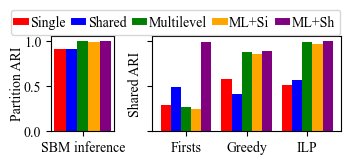

In [130]:
fig, axs = plt.subplots(1, 2, figsize=(plt_width, 1.2), gridspec_kw={'width_ratios': [0.25, 0.75]})

# First subplot
axs[0].bar(single_algorithms, plot_partition_ARIs, color=plot_colors, width=1.0)
axs[0].set_ylabel('Partition ARI', labelpad=0.0)
axs[0].set_xticks([2])
axs[0].set_xticklabels(["SBM inference"])

# Second subplot
excluding_random = np.arange(len(inference_algorithms), len(shared_algorithms))
positions = np.arange(len(shared_algorithms[excluding_random]))
positions[5:] += 1 
positions[10:] += 1

axs[1].bar(positions, plot_binary_shared_ARIs[excluding_random], color=plot_colors[excluding_random], width=1.0)
axs[1].set_xticks([2, 8, 14])
axs[1].set_xticklabels(["Firsts", "Greedy", "ILP"])
axs[1].set_yticklabels([])
axs[1].set_ylabel('Shared ARI', labelpad=0.0)

# Add legend to the second subplot
inference_alg_names = [alg_name for _, alg_name, _ in inference_algorithms]
inference_alg_names = ["Single", "Shared", "Multilevel", "ML+Si", "ML+Sh"]
handles = [plt.Line2D([0], [0], color=color, linewidth=5) for color in plot_colors[:len(inference_algorithms)]]
fig.legend(handles, inference_alg_names, loc='upper center', bbox_to_anchor=(0.5, 1.27), ncol=5, columnspacing=0.6, handletextpad=0.4, labelspacing=0.0, handlelength=0.6)

# Adjust layout
plt.tight_layout(pad=0.0)
plt.subplots_adjust(wspace=0.3)
plt.savefig("figures/Partition_and_Shared_ARI.pdf", bbox_inches='tight')
plt.show()

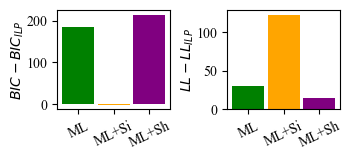

In [297]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(plt_width, 1.4))
bar_width = 0.9

single_i = np.arange(len(inference_algorithms))[2:]
ILP_i = np.arange(len(all_algorithms)-len(inference_algorithms), len(all_algorithms))[2:]
BIC_decrease = plot_BICs[single_i] - plot_BICs[ILP_i]

# Plot decrease in BIC
bars1 = ax1.bar(all_algorithms[ILP_i], BIC_decrease, color=plot_colors[single_i], width=bar_width)
ax1.set_ylabel('$BIC-BIC_{ILP}$', labelpad=0.0)
x_ticklabels = ["ML", "ML+Si", "ML+Sh"]
ax1.set_xticks(np.arange(len(x_ticklabels)))
ax1.set_xticklabels(x_ticklabels, rotation=25)

# Plot decrease in Log-Likelihood
log_likelihood_decrease = plot_log_likelihoods[single_i] - plot_log_likelihoods[ILP_i]
bars2 = ax2.bar(all_algorithms[ILP_i], log_likelihood_decrease, color=plot_colors[single_i], width=bar_width)
ax2.set_ylabel('$LL-LL_{ILP}$', labelpad=0.0)
ax2.set_xticks(np.arange(len(x_ticklabels)))
ax2.set_xticklabels(x_ticklabels, rotation=25)

#handles = [plt.Line2D([0], [0], color=color, linewidth=5) for color in plot_colors[single_i]]
#fig.legend(handles, all_algorithms[single_i], loc='upper center', bbox_to_anchor=(0.36, 1.335), ncol=1, handletextpad=0.4, labelspacing=0.0, handlelength=1.0)

plt.tight_layout(pad=0.0)
plt.subplots_adjust(wspace=0.5)
plt.savefig("figures/Decrease_in_BIC_and_Log_Likelihood.pdf", bbox_inches='tight')
plt.show()

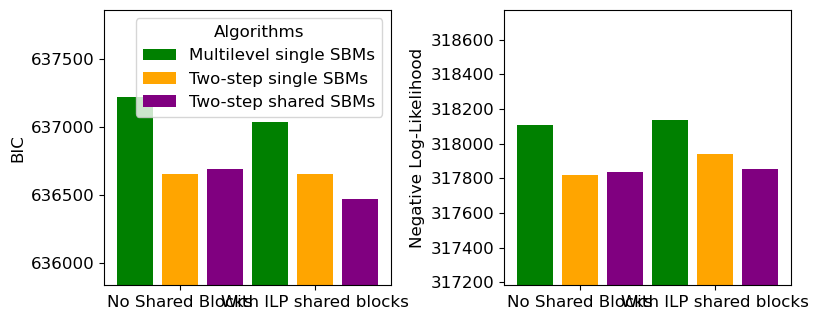

In [302]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

single_i = np.arange(len(inference_algorithms))[2:]
ILP_i = np.arange(len(all_algorithms)-len(inference_algorithms), len(all_algorithms))[2:]
show_i = np.concatenate((single_i, ILP_i))

# Plot BIC
bars1 = ax1.bar(all_algorithms[show_i], plot_BICs[show_i], color=plot_colors[show_i])
ax1.set_ylabel('BIC')
margin = 0.001 * max(plot_BICs[show_i])
ax1.set_ylim(min(plot_BICs[show_i]) - margin, max(plot_BICs[show_i]) + margin)
ax1.set_xticks([1, 4])
ax1.set_xticklabels(['No Shared Blocks', 'With ILP shared blocks'])
ax1.legend(bars1, all_algorithms[show_i][:3], title="Algorithms", loc="upper right")

# Plot Negative Log-Likelihood
bars2 = ax2.bar(all_algorithms[show_i], -np.array(plot_log_likelihoods)[show_i], color=plot_colors[show_i])
ax2.set_ylabel('Negative Log-Likelihood')
ax2.set_ylim(min(-np.array(plot_log_likelihoods)[show_i]) - margin, max(-np.array(plot_log_likelihoods)[show_i]) + margin)
ax2.set_xticks([1, 4])
ax2.set_xticklabels(['No Shared Blocks', 'With ILP shared blocks'])
#ax2.legend(bars2, algorithms[show_i][:3], title="Algorithms", loc="upper right")

plt.tight_layout(pad=0.0)
#plt.savefig("BIC_and_Negative_Log_Likelihood.pdf")
plt.show()

In [115]:
filename = "ARI_noise-result-275072768.txt"
with open(filename, 'r') as file:
    file_content = file.read()

all_algorithms = [
    (shared_blocks_random, "Random"),
    (optimize_shared_blocks_greedy, "Greedy"),
    (optimize_shared_blocks_ILP, "ILP"),
]

noise_mean_ARIs = [[] for i in range(len(all_algorithms))]

mean_score_pattern = re.compile(r'(\w+): mean over \d+ runs: ARIs: \[([0-9. ]+)\], running time \(s\): ([0-9.]+)')
noise_level_pattern = re.compile(r'Noise level:([0-9.]+)')

# Iterate through each line of the file content
noise_level_range = []
for line in file_content.split('\n'):
    match = mean_score_pattern.search(line)
    if match:
        algorithm = match.group(1)
        alg_i = 0 if algorithm == 'Random' else 1 if algorithm == 'Greedy' else 2
        scores = list(map(float, match.group(2).split()))
        noise_mean_ARIs[alg_i].append(scores)
    noise_match = noise_level_pattern.search(line)
    if noise_match:
        noise_level = float(noise_match.group(1))
        noise_level_range.append(noise_level)

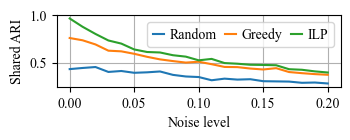

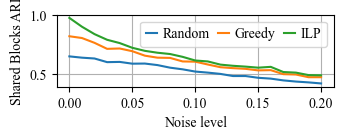

In [128]:
ARI_titles = ["Shared ARI", "Shared Blocks ARI"]
for ARI_index in range(len(noise_mean_ARIs[0][0])):
    ARI_values = [[ARI[ARI_index] for ARI in noise_mean_ARIs[i]] for i in range(len(all_algorithms))]

    plt.figure(figsize=(plt_width, 1.2))
    for i, algorithm in enumerate(all_algorithms):
        _, alg_name = algorithm
        plt.plot(noise_level_range, ARI_values[i], marker=None, label=alg_name)

    plt.xlabel('Noise level')
    plt.ylabel(ARI_titles[ARI_index])
    plt.legend(ncol=3, columnspacing=0.6, handlelength=0.8, handletextpad=0.4)
    plt.grid(True)
    plt.tight_layout(pad=0.0)
    plt.savefig(f'figures/{"_".join(ARI_titles[ARI_index].split(" "))}_vs_noise_level.pdf')
    plt.show()

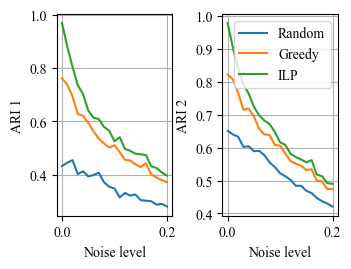

In [225]:
fig, axs = plt.subplots(1, 2, figsize=(plt_width, 2.5), sharex=True)

for ARI_index in range(len(noise_mean_ARIs[0][0])):
    ARI_values = [[ARI[ARI_index] for ARI in noise_mean_ARIs[i]] for i in range(len(all_algorithms))]

    ax = axs[ARI_index]
    for i, algorithm in enumerate(all_algorithms):
        _, alg_name = algorithm
        ax.plot(noise_level_range, ARI_values[i], marker=None, label=alg_name)

    ax.set_xlabel('Noise level')
    ax.set_ylabel(f'ARI {ARI_index+1}')
    if ARI_index == 1:
        ax.legend()
    ax.grid(True)

plt.tight_layout(pad=0.0)
#plt.savefig('ARI_vs_noise_level_combined.pdf')
plt.show()

In [277]:
n_graphs = 2
block_counts = [8] * n_graphs
vertex_counts = [400] * n_graphs
n_shared_blocks_ground_truth = 3
n_shared_blocks_range = range(0,block_counts[0]+1)
using_directed_graphs = True

seed = 1234
np.random.seed(seed)
gt.seed_rng(seed)

n_steps = 100
verbose = True

results_file_name = "n_shared_blocks_inference_results"
if results_file_name is not None:
    log_file = open(results_file_name+".log", "w")

inference_algorithms = [
    #(fit_SBMs_bernoulli, "Single", n_steps),
    #(fit_shared_SBM, "Shared", n_steps),
    #(fit_SBMs, "Multilevel", None),
    #(fit_single_SBMs_twostep, "ML+Single", n_steps),
    (fit_shared_SBM_twostep, "ML+Shared", n_steps),
]
shared_block_optimization_algs = [
    #(shared_blocks_random, "Random"),
    #(firsts_as_shared_blocks, "Firsts"),
    #(optimize_shared_blocks_greedy, "Greedy"),
    (optimize_shared_blocks_ILP, "ILP"),
]

shared_BICs = [[[] for _ in range(len(shared_block_optimization_algs))] for _ in range(len(inference_algorithms))]
inference_results = [None for _ in range(len(inference_algorithms))]

Gs, Ps, shared_block_sets, block_assignments = generate_shared_SBMs(n_graphs, block_counts, vertex_counts, n_shared_blocks_ground_truth, using_directed_graphs, seed=seed)

# compute and store the inference results for algorithms that do not depend on n_shared_blocks
for inference_alg_i, (inference_algorithm, inference_name, n_iter) in enumerate(inference_algorithms):
    np.random.seed(seed)
    gt.seed_rng(seed)
    if inference_algorithm == fit_SBMs:
        states, inferred_block_assignments = inference_algorithm(Gs, block_counts)
    elif inference_algorithm == fit_SBMs_bernoulli or inference_algorithm == fit_single_SBMs_twostep:
        states, inferred_block_assignments = inference_algorithm(Gs, block_counts, n_iter=n_iter)
    else:
        continue
    inference_results[inference_alg_i] = states, inferred_block_assignments

for i, n_shared_blocks in enumerate(n_shared_blocks_range):
    print_log(f"n_shared_blocks: {n_shared_blocks}", log_file, verbose)
    for inference_alg_i, (inference_algorithm, inference_name, n_iter) in enumerate(inference_algorithms):
        np.random.seed(seed)
        gt.seed_rng(seed)
        inference_start_time = datetime.now()
        if inference_results[inference_alg_i] is not None:
            states, inferred_block_assignments = inference_results[inference_alg_i]
        else:
            if inference_algorithm == fit_SBMs:
                states, inferred_block_assignments = inference_algorithm(Gs, block_counts)
            elif inference_algorithm == fit_shared_SBM_twostep:
                states, inferred_block_assignments = inference_algorithm(Gs, block_counts, n_shared_blocks=n_shared_blocks, using_directed_graphs=using_directed_graphs)
            else:
                states, inferred_block_assignments = inference_algorithm(Gs, block_counts, n_shared_blocks=n_shared_blocks, n_iter=n_iter)
            
        inferred_block_counts = get_block_counts(inferred_block_assignments)
        inference_running_time = datetime.now() - inference_start_time
            
        edge_count_matrices, missing_edges_matrices = calculate_edge_counts_and_missing_edges(inferred_block_assignments, Gs, using_directed_graphs)
        inferred_Ps = compute_max_likelihood_params(edge_count_matrices, missing_edges_matrices)
        log_likelihood, BIC = log_likelihood_and_BIC(inferred_Ps, edge_count_matrices, missing_edges_matrices, using_directed_graphs, n_shared_blocks=0)
        print_log(f"    {inference_name} done in: {inference_running_time}, BIC: {BIC}", log_file, verbose)
        for shared_alg_i, (shared_block_alg, shared_block_alg_name) in enumerate(shared_block_optimization_algs):
            shared_block_start_time = datetime.now()
            inferred_shared_Ps, inferred_shared_blocks, inferred_shared_block_sets = shared_block_alg(n_shared_blocks, inferred_Ps, inferred_block_counts, edge_count_matrices, missing_edges_matrices)
            shared_block_running_time = datetime.now() - shared_block_start_time
            total_running_time = inference_running_time + shared_block_running_time
            log_likelihood, BIC = log_likelihood_and_BIC(inferred_shared_Ps, edge_count_matrices, missing_edges_matrices, using_directed_graphs, n_shared_blocks)
            shared_BICs[inference_alg_i][shared_alg_i].append(BIC)
            print_log(f"    {inference_name} with {shared_block_alg_name} shared blocks done in: {total_running_time}, BIC: {BIC}", log_file, verbose)

if results_file_name is not None:
    log_file.close()

    results = inference_algorithms, shared_block_optimization_algs, shared_BICs, n_shared_blocks_range
    with open(results_file_name+".pkl", "wb") as pkl_file:
        pickle.dump(results, pkl_file)

n_shared_blocks: 0
    ML+Shared done in: 0:00:12.354562, BIC: 242437.44394202155
    ML+Shared with ILP shared blocks done in: 0:00:12.768729, BIC: 242437.44394202155
n_shared_blocks: 1
    ML+Shared done in: 0:00:12.277387, BIC: 242437.44394202155
    ML+Shared with ILP shared blocks done in: 0:00:12.886232, BIC: 242425.48276123987
n_shared_blocks: 2
    ML+Shared done in: 0:00:13.391146, BIC: 242437.44394202155
    ML+Shared with ILP shared blocks done in: 0:00:16.237696, BIC: 242390.09901358228
n_shared_blocks: 3
    ML+Shared done in: 0:00:21.240882, BIC: 242437.44394202152
    ML+Shared with ILP shared blocks done in: 0:00:29.842757, BIC: 242334.4979744767
n_shared_blocks: 4
    ML+Shared done in: 0:00:40.283978, BIC: 242437.44394202155
    ML+Shared with ILP shared blocks done in: 0:01:06.600852, BIC: 242935.61495910224
n_shared_blocks: 5
    ML+Shared done in: 0:01:13.070431, BIC: 242437.4439420216
    ML+Shared with ILP shared blocks done in: 0:02:15.600260, BIC: 243667.489223

In [8]:
results = pickle.load(open("n_shared_blocks_inference_results.pkl", "rb"))
inference_algorithms, shared_block_optimization_algs, shared_BICs, n_shared_blocks_range = results
n_shared_blocks_ground_truth = 3

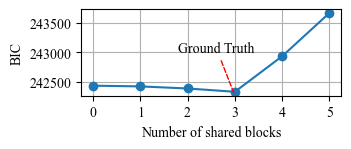

In [21]:
n_plot_first = n_shared_blocks_ground_truth + 3

plt.figure(figsize=(plt_width, 1.3))
for inference_alg_i, (_, inference_alg_name, _) in enumerate(inference_algorithms):
    for shared_alg_i, (_, shared_block_alg_name) in enumerate(shared_block_optimization_algs):
        plt.plot(n_shared_blocks_range[:n_plot_first], shared_BICs[inference_alg_i][shared_alg_i][:n_plot_first], marker='o', label=f"{inference_alg_name}+{shared_block_alg_name}")
ymin, ymax = plt.ylim()
plt.annotate(
    'Ground Truth', xy=(n_shared_blocks_ground_truth, ymin), xycoords='data',
    xytext=(n_shared_blocks_ground_truth-1.2, ymin+(ymax - ymin) / 2), textcoords='data',
    arrowprops=dict(arrowstyle='-', color='r', linestyle='--')
)

plt.xlabel('Number of shared blocks')
plt.ylabel('BIC')
#plt.legend()
plt.grid(True)
plt.tight_layout(pad=0.0)
plt.savefig(f'figures/n_shared_blocks_vs_BIC.pdf')
plt.show()

In [7]:
alg_mean_running_times = pickle.load(open("shared_block_alg_mean_running_times.pkl", "rb"))

algorithms = [
    (shared_blocks_random, "Random"),
    (optimize_shared_blocks_greedy, "Greedy"),
    (optimize_shared_blocks_ILP, "ILP"),
]

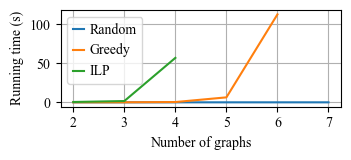

In [8]:
plt.figure(figsize=(plt_width, 1.4))
n_graphs_range = range(2, 8)
alg_times = [[result[1][i] for result in alg_mean_running_times] for i in range(len(algorithms))]

for i, algorithm in enumerate(algorithms):
    _, alg_name = algorithm
    plt.plot(n_graphs_range, alg_times[i], marker=None, label=alg_name)

plt.xlabel('Number of graphs')
plt.ylabel('Running time (s)')
plt.legend(handlelength=0.8, handletextpad=0.4)
plt.grid(True)
plt.tight_layout(pad=0.0)
plt.savefig("figures/shared_block_alg_running_times.pdf", bbox_inches='tight')
plt.show()

In [9]:
results = pickle.load(open("inference_running_times.pkl", "rb"))
inference_algorithms, inference_running_times, n_edges_lists, n_vertices_range, n_tests = results

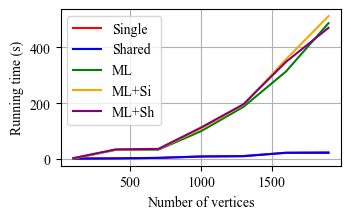

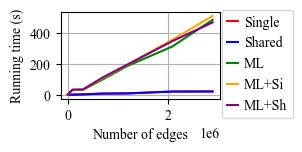

In [10]:
n_steps = 500
inference_algorithms = [
    (fit_SBMs_bernoulli, "Single", n_steps),
    (fit_shared_SBM, "Shared", n_steps),
    (fit_SBMs, "ML", None),
    (fit_single_SBMs_twostep, "ML+Si", n_steps),
    (fit_shared_SBM_twostep, "ML+Sh", n_steps),
]
colors = ['red', 'blue', 'green', 'orange', 'purple']

for i, (_, alg_name, _) in enumerate(inference_algorithms):
    running_times = [t.total_seconds() for t in inference_running_times[i]]
    mean_running_times = []
    for test_i, n_vertices in enumerate(n_vertices_range):
        mean_running_times.append(np.mean(running_times[test_i*n_tests:(test_i+1)*n_tests]))
    plt.plot(n_vertices_range, mean_running_times, marker=None, label=alg_name, color=colors[i])

plt.xlabel('Number of vertices')
plt.ylabel('Running time (s)')
plt.legend()
plt.grid(True)
plt.tight_layout(pad=0.0)
#plt.savefig("figures/inference_running_times_vertices.pdf")
plt.show()

plt.figure(figsize=(plt_width, 1.3))
for i, (_, alg_name, _) in enumerate(inference_algorithms):
    running_times = [t.total_seconds() for t in inference_running_times[i]]
    total_edges = np.sum(n_edges_lists, axis=1)
    mean_running_times = []
    mean_total_edges = []
    for test_i, n_vertices in enumerate(n_vertices_range):
        mean_running_times.append(np.mean(running_times[test_i*n_tests:(test_i+1)*n_tests]))
        mean_total_edges.append(np.mean(total_edges[test_i*n_tests:(test_i+1)*n_tests]))
    plt.plot(mean_total_edges, mean_running_times, marker=None, label=alg_name, color=colors[i])

plt.xlabel('Number of edges')
plt.ylabel('Running time (s)')
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.4), ncol=1, handlelength=0.8, handletextpad=0.4)
plt.grid(True)
plt.tight_layout(pad=0.0)
plt.savefig("figures/inference_running_times_edges.pdf", bbox_inches='tight')
plt.show()

Experiments on brain networks

In [13]:
from nilearn import datasets, plotting, image
from nilearn.connectome import ConnectivityMeasure
from nilearn.input_data import NiftiLabelsMasker
import os

In [14]:
adhd_dataset = datasets.fetch_adhd(n_subjects=40)

# Load the Harvard-Oxford atlas
n_rois = 1000
schaefer_atlas = datasets.fetch_atlas_schaefer_2018(n_rois=n_rois) # up to 1000 (ROI, number nodes) for this atlas
atlas_filename = schaefer_atlas.maps
masker = NiftiLabelsMasker(labels_img=atlas_filename, standardize=True)

connectivity_measure = ConnectivityMeasure(kind='correlation')

node_coords_path = f"../data/brains/node_coords_{n_rois}.pkl"
if os.path.exists(node_coords_path):
    with open(node_coords_path, "rb") as pkl_file:
        node_coords = pickle.load(pkl_file)
else:
    node_coords = plotting.find_parcellation_cut_coords(labels_img=atlas_filename)
    os.makedirs(os.path.dirname(node_coords_path), exist_ok=True)
    with open(node_coords_path, "wb") as pkl_file:
        pickle.dump(node_coords, pkl_file)

In [15]:
n_graphs = 3

phenotypic_data = adhd_dataset['phenotypic']
filter = (
    (phenotypic_data['adhd'] == 1) &
    (phenotypic_data['site'] == '"OHSU"')
)
chosen_i = np.where(filter)[0][:n_graphs]
phenotypic_data[chosen_i]

array([('"27"',   23012, '"rest_1"', 0.057, 0, 0.239, 0.104, 0.   , 16.891, 1.323, '"OHSU"', 'NA', '"test_set"', 11.33, '"F"', '"R"', 'NA', '120', 'NA', 'NA', '2', 0, 1, 'NA', 'NA', 'NA', '""', '""', '""', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', '"pass"', '""', '""', '""', '""', '""', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', '"pass"', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', '""', '""'),
       ('"29"', 1206380, '"rest_1"', 0.072, 1, 0.268, 0.129, 1.266, 16.962, 2.127, '"OHSU"', 'NA', '"data_set"',  9.17, '"M"', '""', 'NA', 'NA', 'NA', 'NA', 'NA', 0, 1, 'NA', 'NA', 'NA', '""', '""', '""', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', '"pass"', '"open"', '"fail"', '"closed"', '""', '""', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', '"pass"', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', '"yes"', '""'),
       ('"25"', 1552181, '"rest_1"', 0.041, 0, 0.202, 0.067, 0.   , 12.809, 0.853, '"OHSU"', 'NA', '"data_set"',  9.83, '"

In [16]:
phenotypic_data[chosen_i]['age']

array([11.33,  9.17,  9.83])

In [17]:
def create_connectivity_matrix(f): 
    m = connectivity_measure.fit_transform([masker.fit_transform(f)])[0]
    np.fill_diagonal(m, 0.0) # no self-loops
    return m
cm = [create_connectivity_matrix(f) for f in np.array(adhd_dataset.func)[chosen_i]]

In [ ]:
Gs = []
adj_matrices = []
edge_cutoff_threshold = 0.5
for connectivity_matrix in cm:
    adj_matrix = (connectivity_matrix >= edge_cutoff_threshold).astype(int)
    adj_matrices.append(adj_matrix)
    # check if the adjacency matrix is symmetric
    if (adj_matrix == adj_matrix.T).all():
        G = nx.from_numpy_array(adj_matrix)
    else:
        G = nx.from_numpy_array(adj_matrix, create_using=nx.DiGraph())
    Gs.append(G)
    print(f"number of nodes: {G.number_of_nodes()}, number of edges: {G.number_of_edges()}")

using_directed_graphs = Gs[0].is_directed()
Gs = convert_to_gt_graphs(Gs, using_directed_graphs)

In [ ]:
total_start_time = datetime.now()

seed = 1
np.random.seed(seed)
gt.seed_rng(seed)

block_counts = [10] * len(Gs)
n_steps = 500
n_shared_blocks = 2
verbose = True

results_file_name = "brain_networks_results"
if results_file_name is not None:
    log_file = open(results_file_name+".log", "w")

inference_algorithms = [
    #(fit_SBMs_bernoulli, "bernoulli single SBMs", n_steps),
    #(fit_shared_SBM, "bernoulli shared SBM", n_steps),
    #(fit_SBMs, "poisson multilevel single SBMs", None),
    #(fit_single_SBMs_twostep, "two-step single SBMs", n_steps),
    (fit_shared_SBM_twostep, "two-step shared SBMs", n_steps),
]
shared_block_optimization_algs = [
    #(shared_blocks_random, "Random"),
    #(firsts_as_shared_blocks, "Firsts"),
    (optimize_shared_blocks_greedy, "Greedy"),
    #(optimize_shared_blocks_ILP, "ILP"),
]
inference_running_times = [[] for _ in range(len(inference_algorithms))]
single_log_likelihoods = [[] for _ in range(len(inference_algorithms))]
single_BICs = [[] for _ in range(len(inference_algorithms))]

total_running_times = [[[] for _ in range(len(shared_block_optimization_algs))] for _ in range(len(inference_algorithms))]
shared_log_likelihoods = [[[] for _ in range(len(shared_block_optimization_algs))] for _ in range(len(inference_algorithms))]
shared_BICs = [[[] for _ in range(len(shared_block_optimization_algs))] for _ in range(len(inference_algorithms))]

for inference_alg_i, (inference_algorithm, inference_name, n_iter) in enumerate(inference_algorithms):
    np.random.seed(seed)
    gt.seed_rng(seed)
    inference_start_time = datetime.now()
    if inference_algorithm == fit_SBMs:
        states, inferred_block_assignments = inference_algorithm(Gs, block_counts, n_shared_blocks=n_shared_blocks)
    elif inference_algorithm == fit_shared_SBM_twostep:
        states, inferred_block_assignments = inference_algorithm(Gs, block_counts, n_shared_blocks=n_shared_blocks, n_iter=n_iter, shared_block_alg=shared_block_optimization_algs[-1][0])
    else:
        states, inferred_block_assignments = inference_algorithm(Gs, block_counts, n_shared_blocks=n_shared_blocks, n_iter=n_iter)
    
    inferred_block_counts = get_block_counts(inferred_block_assignments)
    if block_counts[0] is None:
        print(f"inferred_block_counts: {inferred_block_counts}")
    inference_running_time = datetime.now() - inference_start_time
    inference_running_times[inference_alg_i].append(inference_running_time)
        
    edge_count_matrices, missing_edges_matrices = calculate_edge_counts_and_missing_edges(inferred_block_assignments, Gs, using_directed_graphs)
    inferred_Ps = compute_max_likelihood_params(edge_count_matrices, missing_edges_matrices)
    log_likelihood, BIC = log_likelihood_and_BIC(inferred_Ps, edge_count_matrices, missing_edges_matrices, using_directed_graphs, n_shared_blocks=0)
    single_log_likelihoods[inference_alg_i].append(log_likelihood)
    single_BICs[inference_alg_i].append(BIC)
    print_log(f"{inference_name} done in: {inference_running_time}, log-likelihood: {log_likelihood}, BIC: {BIC}", log_file, verbose)
    for shared_alg_i, (shared_block_alg, shared_block_alg_name) in enumerate(shared_block_optimization_algs):
        shared_block_start_time = datetime.now()
        inferred_shared_Ps, inferred_shared_blocks, inferred_shared_block_sets = shared_block_alg(n_shared_blocks, inferred_Ps, inferred_block_counts, edge_count_matrices, missing_edges_matrices)
        shared_block_running_time = datetime.now() - shared_block_start_time
        total_running_time = inference_running_time + shared_block_running_time
        log_likelihood, BIC = log_likelihood_and_BIC(inferred_shared_Ps, edge_count_matrices, missing_edges_matrices, using_directed_graphs, n_shared_blocks)
        total_running_times[inference_alg_i][shared_alg_i].append(total_running_time)
        shared_log_likelihoods[inference_alg_i][shared_alg_i].append(log_likelihood)
        shared_BICs[inference_alg_i][shared_alg_i].append(BIC)
        print_log(f"{inference_name} with {shared_block_alg_name} shared blocks done in: {total_running_time}, log-likelihood: {log_likelihood}, BIC: {BIC}\\\n", log_file, verbose)

if results_file_name is not None:
    results = inference_algorithms, shared_block_optimization_algs, inference_running_times, single_log_likelihoods, single_BICs, total_running_times, shared_log_likelihoods, shared_BICs
    with open(results_file_name+".pkl", "wb") as pkl_file:
        pickle.dump(results, pkl_file)


In [ ]:
colors = ['blue', 'red', 'yellow', 'green', 'purple', 'orange', 'black', 'grey', 'brown']
node_colors = [dict({v: 'pink' for v in Gs[k].vertices()}) for k in range(len(Gs))]
for k, G in enumerate(Gs):
    for i_shared_block, shared_block in enumerate(inferred_shared_block_sets[k]):
        vertices_in_shared_block = np.array([int(v) for v in G.vertices() if inferred_block_assignments[k][int(v)] == shared_block])
        node_colors[k].update({v: colors[i_shared_block] for v in vertices_in_shared_block})

In [ ]:
for i, G in enumerate(Gs):
    #adj_matrix = np.array(gt.adjacency(G).todense())
    adj_matrix = np.zeros((G.num_vertices(), G.num_vertices()))
    node_colors_list = [node_colors[i][v] for v in range(len(node_coords))]
    plotting.plot_connectome(adj_matrix, node_coords, node_size=10, node_color=node_colors_list, edge_kwargs={'color': 'pink'})
    plt.title(f'Brain Network for Subject {i+1}')
    plt.show()

In [ ]:
from matplotlib.transforms import Bbox
brain_plot_width = 5.0
brain_plot_height = 2.0
brain_order = [1,2,0]
fig, axes = plt.subplots(1, 3, figsize=(brain_plot_width, brain_plot_height))
for i, G in enumerate(Gs):
    brain_i = brain_order[i]
    adj_matrix = np.zeros((G.num_vertices(), G.num_vertices()))
    node_colors_list = [node_colors[brain_i][v] for v in range(len(node_coords))]
    plotting.plot_connectome(adj_matrix, node_coords, figure=fig, node_size=3.0, node_color=node_colors_list, display_mode="z", axes=axes[i], edge_kwargs={'color': 'pink'})

bbox = Bbox.from_extents(0.6, 0.3, brain_plot_width-0.5, brain_plot_height-0.3)
plt.savefig("figures/adhd_brains.pdf", bbox_inches=bbox)
plt.show()